In [0]:
import gym
from gym import spaces
import numpy as np
import random
import time
from datetime import timedelta
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

In [0]:
def argmax(q_values):
    q_max = np.max(q_values)
    q_where = [x[0] for x in np.argwhere(q_values == q_max)]

    return np.random.choice(q_where)
    
def train(env, num_episodes, max_steps_per_episode, learning_rate, discount_rate, exploration_rate, exploration_decay_rate, min_exploration_rate, max_exploration_rate, observation_step_size=100, mode='q_learning'):
    action_space_size = env.action_space.n
    state_space_size = env.observation_space.n

    q_table = np.zeros((state_space_size, action_space_size))

    observation = [0]
    rewards = 0
    start_time = time.perf_counter()
    end_time = 0
    time_elapsed = 0
    time_required = 0

    # Loop over all the episodes
    for episode in range(1, num_episodes + 1): 
    #     Reset Environment before each episode begins
        state = env.reset()
            
    #     done keeps track of whether or not the episode has ended
        done = False
        rewards_current_episode = 0
        prev_state = None
        prev_action = None

    #     Run each step in an wpisode
        while not done:
    #         Get a random exploration threshold
            exploration_rate_threshold = random.uniform(0, 1)
            
    #         Exploitation
            if exploration_rate_threshold > exploration_rate:
                action = argmax(q_table[state, :])
    #         Exploration
            else:
                action = env.action_space.sample()
            
    #         Take the action
            new_state, reward, done, info = env.step(action)
            
            q_max = np.max(q_table[new_state, :])
            if mode == 'q_learning':
                q_table[state, action] = q_table[state, action] * (1 - learning_rate) + \
                    learning_rate * (reward + discount_rate * q_max)                
            elif mode == 'expected_sarsa':
                pi = np.ones(action_space_size) * exploration_rate / action_space_size \
                    + (q_table[new_state,:] == q_max) * (1 - exploration_rate) / np.sum(q_table[new_state,:] == q_max)
                expected_q = np.sum(q_table[new_state,:] * pi)
            
                q_table[state, action] = q_table[state, action] * (1 - learning_rate) + \
                    learning_rate * (reward + discount_rate * expected_q)
            elif mode == 'sarsa' and prev_state is not None and prev_action is not None:
                q_table[prev_state, prev_action] = q_table[state, prev_action] * (1 - learning_rate) + \
                    learning_rate * (reward + discount_rate * q_table[state, action])

            prev_state = state
            prev_action = action

            state = new_state
            rewards_current_episode += reward

    #     Update Exploration Rate
        exploration_rate = min_exploration_rate + \
            (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate * episode)
        rewards += rewards_current_episode / observation_step_size
        
        if episode % observation_step_size == 0:
            observation.append(rewards)
            rewards = 0

            time_elapsed = (time_elapsed + time.perf_counter() - start_time) / 2
            time_required = int(((num_episodes - episode) / observation_step_size) * time_elapsed)
            start_time = time.perf_counter()
        
        print(f'\rMode: {mode_to_name(mode)}\tETA: {timedelta(seconds=int(time_required))}\tEpisode: {episode}/{num_episodes}\tObservation: {observation[-1]:.2f}\tExploration Rate: {exploration_rate:.5f}', end='')
    
    return q_table, observation[1:]

def mode_to_name(mode):
    return ' '.join([word.capitalize() for word in mode.split('_')])

def train_and_compare(env, num_episodes, max_steps_per_episode, learning_rate, discount_rate, exploration_rate, exploration_decay_rate, min_exploration_rate, max_exploration_rate, observation_step_size=100, modes=None):
    result = {'modes': modes, 'observation_step_size': observation_step_size}
    
    for mode in modes:
        result[mode] = [None, None, None]
        start_training = time.perf_counter()
        result[mode][0], result[mode][1] = train(env, num_episodes, max_steps_per_episode, learning_rate, discount_rate, exploration_rate, exploration_decay_rate, min_exploration_rate, max_exploration_rate, observation_step_size, mode)
        end_training = time.perf_counter()
        result[mode][2] = int(end_training - start_training)
        
    return result

def display_result(result, print_observations=True, plot_obsevations=True, print_training_times=True, print_steps=True):
    modes = result['modes']
    observation_step_size = result['observation_step_size']

    if print_observations:
        for mode in modes:
            for i, v in enumerate(result[mode][1]):
                print(f'{mode_to_name(mode)} -> {i + 1}: {v:.2f}')
    
    if plot_obsevations:
        for mode in modes:
            plt.plot([i * observation_step_size for i in range(1, len(result[mode][1]) + 1)], result[mode][1])
        
        plt.ylabel('Reward')
        plt.xlabel('Number of Episodes')
        plt.title('Training Progress')
        plt.legend([mode_to_name(mode) for mode in modes])
        plt.show()    
    
    if print_training_times:
        for mode in modes:
            print(f'\rTraining Time: {timedelta(seconds=result[mode][2])}{" " * 100}')
    
    if print_steps:
        print()
        for mode in modes:
            print(f'{mode_to_name(mode)}:')
            print(f'\nSteps: {steps(result[mode][0])}\n')

def display(q_table, dim):
    output = np.full((dim, dim), '')

    for i in range(dim):
        for j in range(dim):
            direction = np.argmax(q_table[dim * i + j, :])
            if direction == 0:
                output[i, j] = '\u21e6'
            elif direction == 1:
                output[i, j] = '\u21e9'
            elif direction == 2:
                output[i, j] = '\u21e8'
            else:
                output[i, j] = '\u21e7'

    output = [''.join(output[i]) for i in range(dim)]
    output = '\n\n'.join(output)

    print(output)

def steps(env, q_table):
    done = False
    state = 0
    env.reset()
    steps = []
    num_steps = 1

    while not done:
        action = argmax(q_table[state, :])
        # actiosn = env.action_space.sample()
        state, reward, done, info = env.step(action)
        steps.append(env.possition(state))
        time.sleep(1)
        print(f'\rCurrent Time Step: {num_steps}\tCurrent Possition: {steps[-1]}', end='')
        num_steps += 1

    return steps

In [0]:
class GridworldEnv(gym.Env):
    """
      A simple Grid World

      Actions: 
          Value ->  Interpritation
          0     ->  Move Left 
          1     ->  Move Down
          2     -> Move Right
          3     -> Move Up

      States:
          [0-(dim ** 2 - 1)]
          Conversion from state to possition:
              possition = state // dim, state % dim
          Conversion from possition to state
              state = possition[0] * dim + possition[1]
    """

    def __init__(self, dim, special_transistions={}):
        dim_sq = dim * dim
        self.dim = dim
        self.special_transistions = special_transistions
        self.start_state = 0
        self.goal_state = dim_sq - 1
        self.current_state = 0
        
        self.reward_range = (-1, 0)
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Discrete(dim_sq)

        gridworld = np.arange(self.observation_space.n).reshape((dim, dim))
        self.P = np.full((self.observation_space.n, self.action_space.n, 4), None)

        for state in range(self.observation_space.n):
            if state == self.goal_state:
                self.P[state] = [[state, 0, True, {}]] * self.action_space.n
                continue

            row, col = np.argwhere(gridworld == state)[0]

            for a, d in zip(
                    range(self.action_space.n),
                    [(0, -1), (1, 0), (0, 1), (-1, 0)]
                    ):
                next_row = max(0, min(row + d[0], dim - 1))
                next_col = max(0, min(col + d[1], dim - 1))
                next_state = gridworld[next_row, next_col]

                if next_state == self.goal_state:
                    self.P[state, a] = [next_state, 0, True, {}]
                elif next_state in self.special_transistions:
                    self.P[state, a] = [self.special_transistions[next_state], -1, False, {}]
                else:
                    self.P[state, a] = [next_state, -1, False, {}]

    def step(self, action):
        self.current_state, reward, terninated, info = self.P[self.current_state, action]
        return self.current_state, reward, terninated, info
    
    def possition(self, state):
        return state // self.dim, state % self.dim

    def state(self, possition):
        return possition[0] * self.dim + possition[1]

    def reset(self):
        self.current_state = self.start_state
        return self.current_state

    def render(self):
        output = np.full((self.dim, self.dim), '-')

        output[self.possition(self.start_state)] = 'S'
        output[self.possition(self.goal_state)] = 'G'
        output[self.possition(self.current_state)] = 'X'
        
        output = [''.join(output[i]) for i in range(self.dim)]
        output = '\n'.join(output)
        
        print(output)

In [0]:
env = GridworldEnv(dim=100, special_transistions={98:9990, 97:5, 99:10, 9998: 10})
# env = gym.make('FrozenLake8x8-v0')
# list(gym.envs.registry.env_specs.keys())

In [0]:
# Set Hyperparameter Values
num_episodes = 5000
max_steps_per_episode = 10000

learning_rate = 1
discount_rate = 1

exploration_rate = 0.0
max_exploration_rate = 0.0
min_exploration_rate = 0.0000
exploration_decay_rate = 0.000

observation_step_size = 50
modes = ['sarsa', 'expected_sarsa', 'q_learning']

In [0]:
result = train_and_compare(env, num_episodes, max_steps_per_episode, learning_rate, discount_rate, exploration_rate, 
                            exploration_decay_rate, min_exploration_rate, max_exploration_rate, observation_step_size, modes)

Mode: Q Learning	ETA: 0:00:00	Episode: 5000/5000	Observation: -110.00	Exploration Rate: 0.00000

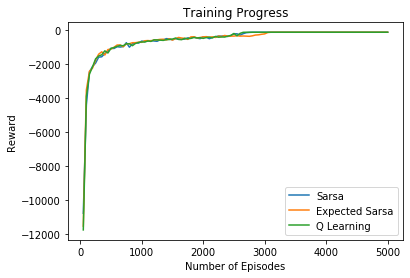

Training Time: 0:02:44                                                                                                    
Training Time: 0:04:48                                                                                                    
Training Time: 0:02:40                                                                                                    

Sarsa:
Current Time Step: 113	Current Possition: (99, 99)
Steps: [(1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (1, 60), (1, 61), (1, 62), (1, 63)

In [0]:
display_result(result=result, print_observations=False)